Dataset found at : https://github.com/nicknochnack/ImageClassification


Libraries used for now, will be updated whilst coding something useful


In [1]:
import tensorflow as tf
import os

2025-02-24 21:05:19.776501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 21:05:19.803495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 21:05:19.811567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 21:05:19.902727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


avoid OOM errors by setting gpu usage


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1740427522.139821    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740427522.303045    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740427522.303286    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Remove all images corrupted or bad


In [3]:
import cv2
import imghdr

/tmp/ipykernel_2329/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'
image_extensions = ['jpeg','jpg','bmp','png']

Loop to remove all useless images


In [5]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Load Dataset using a Pipeline


In [6]:
import numpy as np
import matplotlib.pyplot as plt 

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data')  #change batch_size param in case you have low specs 

Found 305 files belonging to 2 classes.


I0000 00:00:1740427526.723155    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740427526.723406    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740427526.723565    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740427526.796379    2329 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
data_iterator = data.as_numpy_iterator() #access generator from pipeline as iterator


rerun to get different batches


In [9]:
batch = data_iterator.next() #batch has 2 fields: data(image) and label

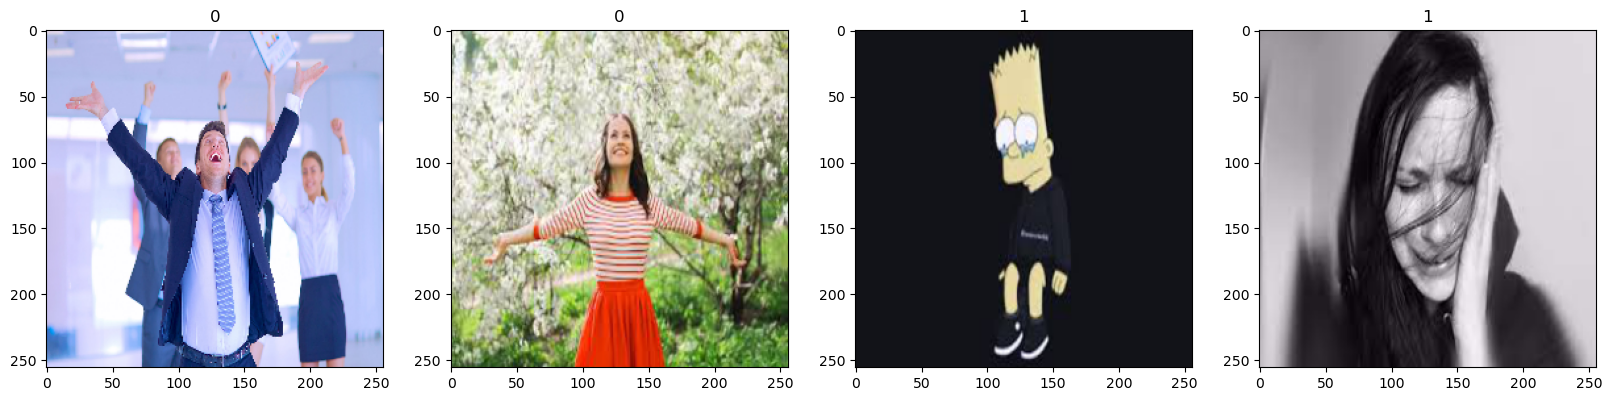

In [10]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    #ax[idx].title.set_text('happy' if batch[1][idx]<=0.5 else 'sad')
    ax[idx].title.set_text(batch[1][idx])

Preprocessing data
we gotta make it fast and good baby!


Scale data


In [11]:
scaled = batch[0]/255
scaled.max()

1.0

In [12]:
data = data.map(lambda x,y :(x/255,y)) # x images (indp var) y label 255 scaling

In [13]:
data.as_numpy_iterator().next()[0].max()

1.0

In [14]:
len(data)

10

So now we split the data into test, trainain and validation sets.


In [15]:
train_size= int(len(data)*.7)
val_size= int(len(data)*.2)
test_size= int(len(data)*.1)

print('Train size:', train_size, 'Validation Size : ', val_size,'Testing  Size:' , test_size )   ##70% for training and rest two are used as validation.   

Train size: 7 Validation Size :  2 Testing  Size: 1


In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)   ## skipping the train part to get val set from remaining dataset (remaining is testset )
test = data.skip(train_size+val_size).take(test_size )   ## skipping the train & val part to get testing set from remaining dataset    

Add layers to the model


In [17]:
from matplotlib import units


model = tf.keras.models.Sequential()     ## Initialize a sequential model  
model.add(tf.keras.layers.Input(shape = (256,256,3))) #256x256 pixels and 3 channels

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size= (3,3),strides=1,activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D())   ## Max pool layer for downsampling the image data  

model.add(tf.keras.layers.Conv2D (filters =32 , kernel_size  = (3,3), strides = 1,activation ='relu'))   
model.add(tf.keras.layers.MaxPooling2D())     ## Max pool layer for downsampling the image data     


model.add(tf.keras.layers.Conv2D(filters=16,kernel_size= (3,3),strides=1,activation ='relu'))
model.add(tf.keras.layers.MaxPooling2D())   ## Max pool layer for downsampling the image data  

model.add(tf.keras.layers.Flatten() )     ## Flattern Layer to convert our input into a single long vector so that we can feed it in fully connected layers 

model.add(tf.keras.layers.Dense(units=256,activation ='relu'))     ## Fully Connected layer with one neuron (dense layer), and use ReLU as activation function  
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid') )     ## Output Layer (also called Dense Layers) using sigmoid Activation Function for binary classification   

In [18]:
model.compile(optimizer = 'adam', loss  = tf.keras.losses.binary_crossentropy, metrics =  ['accuracy'])   ## Compile the model with Adam optimiser and Binary Cross Entropy Loss function  (for a multi-class classification problem)   

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Now we train


In [20]:
import tensorboard


logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)   ## Tensoboard callback for visualizing the training process in a web browser   

In [21]:
hist = model.fit(train, epochs=20 , validation_data = val,callbacks  = [tensorboard_callback])   

Epoch 1/20


I0000 00:00:1740427531.040702    2445 service.cc:146] XLA service 0x74b860204450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740427531.040811    2445 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-24 21:05:31.152220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-24 21:05:31.325247: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3932 - loss: 1.7555

I0000 00:00:1740427533.489276    2445 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.4050 - loss: 1.6182 - val_accuracy: 0.5312 - val_loss: 0.6674
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.5658 - loss: 0.6734 - val_accuracy: 0.5156 - val_loss: 0.6585
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.5751 - loss: 0.6332 - val_accuracy: 0.6250 - val_loss: 0.6147
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.6986 - loss: 0.6076 - val_accuracy: 0.5625 - val_loss: 0.6851
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.6477 - loss: 0.6417 - val_accuracy: 0.8438 - val_loss: 0.5329
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.8447 - loss: 0.5114 - val_accuracy: 0.8594 - val_loss: 0.3756
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.7996 - loss: 0.4580 - val_accuracy: 0.8594 - val_loss: 0.3427
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.8400 - loss: 0.3949 - val_accuracy: 0.8125 - val_loss: 0.4291
Epo

Look at the performance


In [22]:
# Plotting Accuracy and Loss over Epochs for Training & Validation Data sets.  
# https:%tensorboard --logdir logs to look it using tensorboard

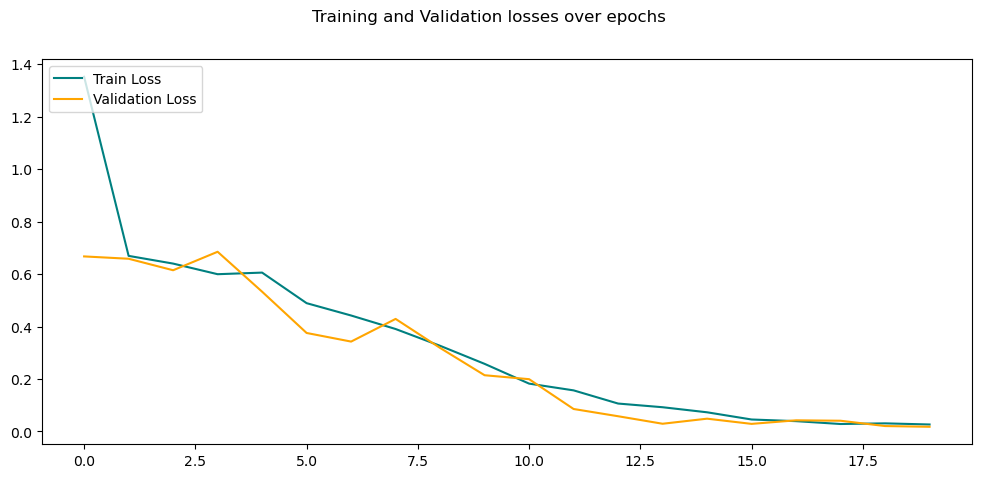

In [23]:
fig = plt.figure(figsize = (12,5))    # Create a new figure instance """    
plt.plot(hist.history['loss'],color= 'teal', label = 'Train Loss')    
plt.plot(hist.history ['val_loss'], color = "orange",label  ="Validation Loss")   
fig.suptitle('Training and Validation losses over epochs ')      
plt.legend(loc= "upper left")
plt.show()

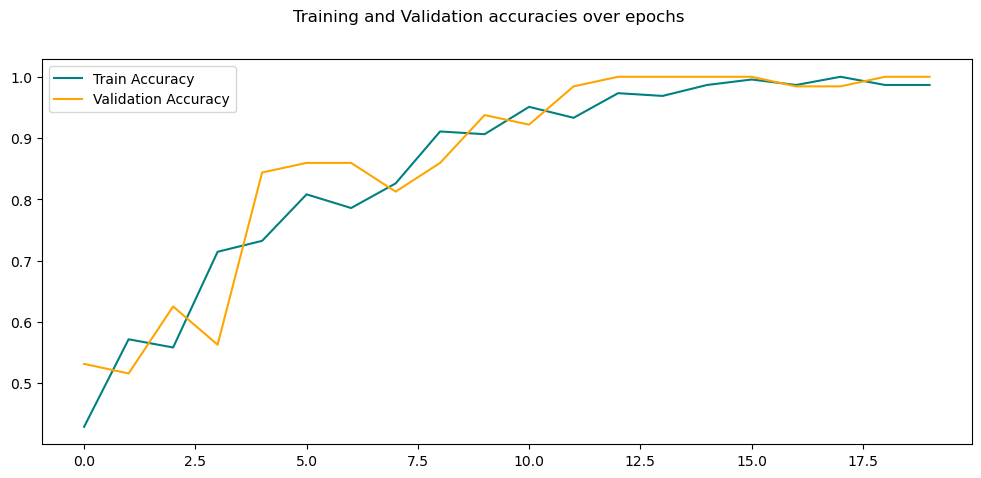

In [24]:
fig = plt.figure(figsize = (12,5))    # Create a new figure instance """    
plt.plot(hist.history['accuracy'],color= 'teal', label = 'Train Accuracy')    
plt.plot(hist.history ['val_accuracy'], color = "orange",label  ="Validation Accuracy")   
fig.suptitle('Training and Validation accuracies over epochs ')      
plt.legend(loc= "upper left")
plt.show()

Evaluate performance


In [25]:

pre = tf.keras.metrics.Precision()
re =  tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()   


In [26]:
len(test)

1

In [27]:
for batch in test.as_numpy_iterator():   
    X , y =batch
    predictions = model .predict(X)   
    pre.update_state(y,predictions )
    re.update_state(y,predictions )
    acc.update_state(y,predictions )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


2025-02-24 21:06:13.960795: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
print(f'Precision: {pre.result().numpy()*100:.2f}%,Recall : {re.result().numpy() *  100 }% , Accuracy : {acc.result().numpy() *  100 }%')

Precision: 100.00%,Recall : 100.0% , Accuracy : 100.0%


Save model


In [30]:
# Importing necessary libraries for saving and loading models in TensorFlow's Keras API load
model.save("emotion_detection.keras")   # Saving the trained emotion detection model to disk 


In [31]:
loaded_model = tf.keras.models.load_model('emotion_detection.keras')   # Loading saved Model for prediction on new data using loaded weights (optional)    

In [ ]:
from pillow import Image
import random 
def get_random_image_path(folder_path):
    try:
        files = os.listdir(folder_path)
        # Filter the list to get only image files 
        images = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

        if not images:
            print("No images found in the specified folder.")
            return None

        # Choose a random image file
        random_image = random.choice(images)
        random_image_path = os.path.join(folder_path, random_image)
        print(f"Here the random image path from the folder:")
        return random_image_path
      
    except Exception as e:
        print(f"An error occurred while selecting image randomly: {e}")
        return None


def display_image(image_path):
    try:
        if image_path and os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img.show()
                print(f"Displayed image: {image_path}")
        else:
            print(f"Invalid image path: {image_path}")
    except Exception as e:
        print(f"An error occurred while displaying the image: {e}")

def show_random_image_from_folder(folder_path):
    predictions = None
    random_image_path = get_random_image_path(folder_path)
    display_image(random_image_path)
    cv2.imread(random_image_path)
    resized  = tf.image.resize(img,(256,256))
    predictions = loaded_model.predict(np.expand_dims(resized/255,0))
    print(predictions)
    print('Predicted Emotion:', 'happy' if predictions <=.5 else 'sad')   # Assuming that the threshold is set to be above or equal to .5

In [43]:
folder_path = ['./data/happy', './data/sad']
random_path = random.choice(folder_path)
if os.path.isdir(random_path):
    show_random_image_from_folder(random_path)
else:
    print(f" The specified folder does not exist: {random_path}")

Here the random image path from the folder:
Displayed image: ./data/happy/image4.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[0.99982065]]
Predicted Emotion: sad
